# Práctica Minería de Datos

**David Jesús Peña Muñoz**

In [1]:
# Import de funciones y librerias.

from NuestrasFunciones import *

#Funciones de Statsmodels
from statsmodels.formula.api import ols
import statsmodels.tsa.holtwinters as ets

from pandas.plotting import autocorrelation_plot

#Modelos ARIMA y SAMRIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Imputación multivariante Iterativa
import sklearn.impute as skl_imp
from sklearn.experimental import enable_iterative_imputer

#* Libreria para escalar los datos
from sklearn.preprocessing import scale

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

# Load library
from pca import pca

#Definicion de funciones accesoras a NuestrasFunciones

## Pregunta 1

Indica en el siguiente chunk el código necesario para importar el conjunto de datos **"FEV_data.csv"** y muestra la información del archivo. 

Información sobre el archivo aquí: 
https://view.officeapps.live.com/op/view.aspx?src=http%3A%2F%2Fwww.emersonstatistics.com%2Fdatasets%2Ffev.doc&wdOrigin=BROWSELINK

In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Lectura del archivo

FEV_data= pd.read_csv('Datos\\FEV_data.csv')

# Información

print("El número de registros en el DataFrame es:", len(FEV_data))

FEV_data.info()

El número de registros en el DataFrame es: 654
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   seqnbr  654 non-null    int64  
 1   subjid  654 non-null    int64  
 2   age     654 non-null    int64  
 3   fev     654 non-null    float64
 4   height  654 non-null    float64
 5   sex     654 non-null    int64  
 6   smoke   654 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 35.9 KB


¿Cuantos registros y variables tiene el archivo? 

**Respuesta**:

- El archivo tiene 7 variables y 654 registros.

¿Tienen las variables el tipo correcto en relación a su lógica naturaleza?

**Respuesta**:

- Las variables sex y smoke se presentan de tipo enteras, cuando al ser dicotómicas, deberían ser factores.

In [3]:
# Corrección de tipos en caso de necesidad

#Creamos la lista de variables para convertir a factor
to_factor = list(FEV_data.loc[:,FEV_data.nunique() <= 2]);
print(to_factor)

#Convertimos variables a factores
FEV_data[to_factor] = FEV_data[to_factor].astype('category')

#Mostramos info del dataset para comprobar que sex y smoke han pasado a ser categóricas.
FEV_data.info()

['sex', 'smoke']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   seqnbr  654 non-null    int64   
 1   subjid  654 non-null    int64   
 2   age     654 non-null    int64   
 3   fev     654 non-null    float64 
 4   height  654 non-null    float64 
 5   sex     654 non-null    category
 6   smoke   654 non-null    category
dtypes: category(2), float64(2), int64(3)
memory usage: 27.2 KB


En cuanto al rol de las variables, ¿son todas válidas como predictores en modelo? 


**Respuesta**:

- Las variables seqnbr y subjid son variables de tipo identificativo, sirven para identificar al individuo y al caso respectivamente, no aportan nada en cuanto a predicción, no deben entrar a nuestro modelo. 

In [4]:
# Eliminación de variables por rol en caso de necesidad

# Guardo el conjunto si las variables de id.
FEV_data_noId = FEV_data.drop(['seqnbr','subjid'],axis=1)

# Guardo el conjunto sin las variabels id, ni la variable objetivo fev
imputfev = FEV_data.drop(['seqnbr','subjid','fev'],axis=1)

#Guardo la variable objetivo continua fev de forma individual.
varObjCont = FEV_data.fev

## Pregunta 2

Sabiendo que la variable objetivo es *Fev*. Presenta un gráfico con las relaciones de asociación de los predictores frente a Fev. 

> Voy a sacar un ranking de efectos a priori por V de Cramer, que nos mestra las relaciones contando solo el efecto marginal de esa variable con la objetivo sin considerar interacciones existentes. Después de esto, voy a sacar un gráfico de relaciones entre las variables predictores numéricas y la variable objetivo, junto con otro conjunto de graficos de relacion entre variables cotegóricas y la variable objetivo para ver posibles patrones de asociación, y elegir las 3 variables que van a conformar mi modelo.


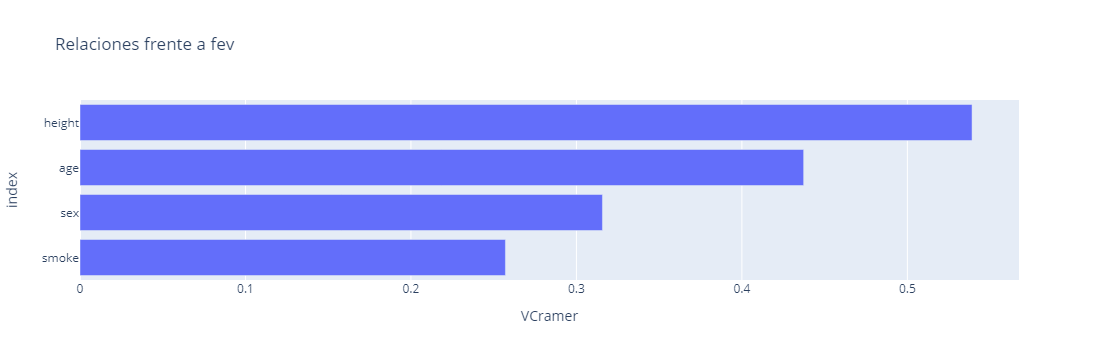

In [5]:
# Gráfico de relaciones v de cramer con la objetivo

tablaCramer = pd.DataFrame(imputfev.apply(lambda x: cramers_v(x,varObjCont)),columns=['VCramer'])
px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente a fev').update_yaxes(categoryorder="total ascending")

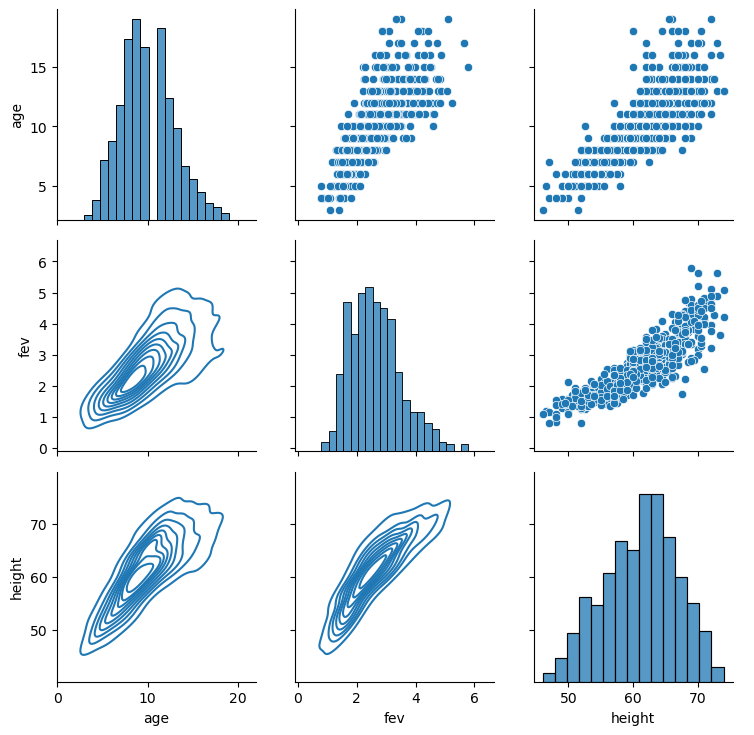

In [6]:
# Gráfico de relaciones con la objetivo para variables numéricas

g = sns.PairGrid(FEV_data_noId.iloc[:,:]) 
g.map_diag(sns.histplot)     # (Diagonal) Histograma de cada variables 
g.map_lower(sns.kdeplot)     # (Triangular superior) Graficos de nivel, para ver como va evolucionando.
g.map_upper(sns.scatterplot) # (Triangular superior)   Uso scatterplot para cruce de variables de tipo continuo. 
g.add_legend()

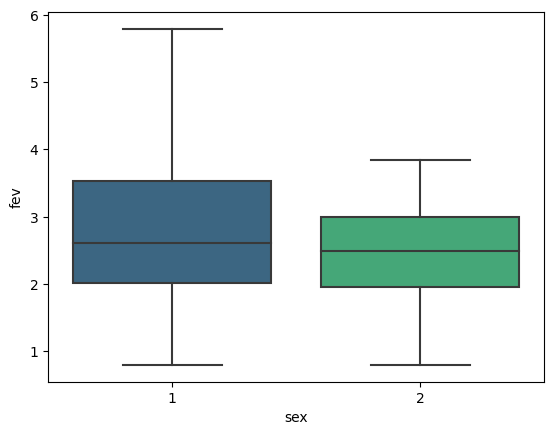

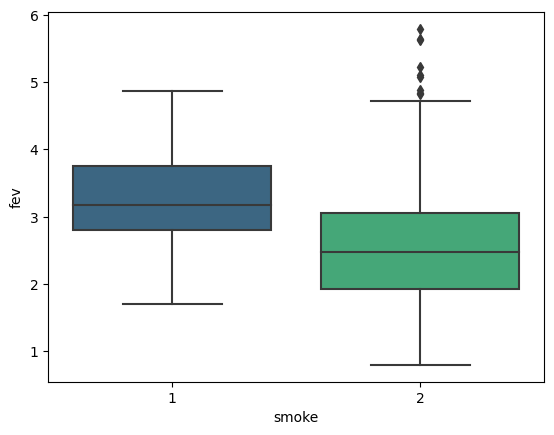

In [7]:
#Grafico para visionar la relacion entre las variables categóricas (sex y smoke, con fev)

plt.clf()
sns.boxplot(x='sex',y='fev',data=FEV_data,palette='viridis')
plt.show()

plt.clf()
sns.boxplot(x='smoke',y='fev',data=FEV_data,palette='viridis')
plt.show()

¿Cuales son las 3 variables que elegirías para tu primer modelo de regresión en base a esta información?

**Respuesta**:

Sin lugar a dudas, las 2 variables numéricas age y height, presentan un patron claramente ascendente, a cuanta mayor edad y peso, mayor es el valor de fev.

En cuanto a las 2 variables categóricas sex y smoke, la variable sex, presenta un patrón curioso, para valores de sex='1' (male), los valores que toma fev estan dispuestos en un rango más amplio que para los valores que toma sex='2' (female), donde los valores de la distribución se encuentran más concentrados a la media, sin embargo, el valor medio de la distribución de las 2 categorías de la variable sex es bastante similar.

La variable smoke, toma valores respecto a la variable objetivo 'fev' mayores en termino medio en la categoría de smoke = 1 (persona fumadora), es decir, si eres fumador tienes de media un fev con valores más altos, algo que a priori parece anti intuitivo si establecemos que un valor más alto de fev está asociado a una funcion respiratoria mejor, aparecen también lo que a priori pudieran parecer outliers para smoke = 2 ( el individuo no fuma), casos que tendríamos que analizar, ya que tiene sentido que si no eres fumador, tu fev sea mayor.

Por otro lado, el ranking de efectos a priori por V de cramer, nos indicaba que los 3 predictores con efectos más significativos eran height, age y sex, por lo que ante la duda entre elegir smoke o sex para nuestro modelo, nos fiamos más del resultado que nos ha dado v de cramer que de nuestra evaluación visual. 

Es decir, voy a elegir ***age***, ***height*** y ***sex*** como predictores para conformar el modelo.

## Pregunta 3

Ajusta el modelo de regresión que contiene los 3 predictores que has decidido en el apartado anterior en el propio conjunto de entrenamiento (no hace falta hacer partición) y muestra el summary de dicho modelo. 

In [8]:
# Ajuste de modelo 

#Definimos formula de modelo
formula = 'fev ~ age + height + sex '

# Ajuste de modelo completo de forma sencilla sin particion mediante fórmula (ols)
results_modelo_sex = ols(formula,data=FEV_data).fit()

# Summary
results_modelo_sex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    fev   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     744.6
Date:                Thu, 14 Mar 2024   Prob (F-statistic):          9.05e-210
Time:                        22:49:28   Log-Likelihood:                -346.99
No. Observations:                 654   AIC:                             702.0
Df Residuals:                     650   BIC:                             719.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2874      0.230    -18.621      0.000      -4.740      -3.835
sex[T.2]      -0.1611      0.033     -4.864      0.000      -0.226      -0.096
age            0.0614      0.009      6.766      0.000       0.044       0.079
height         0.1046      0.005     21.986      0.000       0.095       0.114
==============================================================================
Omnibus:                       23.453   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.454
Skew:                           0.189   Prob(JB):                     4.96e-11
Kurtosis:                       4.264   Cond. No.                         890.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 A la vista de los valores de ajuste, ¿qué porcentaje de variabilidad explicada tiene el modelo? Interpreta el parámetro estimado de la *altura*.

**Respuesta**:

- El modelo tiene un valor del R cuadrado de 0.775, por lo que tiene una variabilidad explicada de un 77.5%
 
> ***height***:
    <p> - ***coef  0.1046*** - Indica el valor de la beta de height, es decir, cuanto aumenta la variable objetivo (fev), cuando aumenta una unidad este parámetro, teniendo en cuenta que las demás variables permanecen constantes, (ceteris paribus).
    <p>- ***std err: 0.005*** - Error estandard de estimación de 0.005.
    <p>- ***t: 21.986*** - Estadístico de contraste para el contraste de hipótesis que hay dentro de los modelos de regresión, el contraste sobre cada uno de los parámetros. 
   <p> - ***P>|t|: 0.000*** - Contraste de significación paramétrica de t de student,  nos indica el p-valor de ese parametro, un valor por debajo de 0.05 indica que ese parámetro es significativo.
    <p>- ***[0.025	0.975]***: 0.095	0.114 - Intervalo de confianza al 95%, aqui comprobamos si el intervalo tiene implicito un cambio de signo, es decir, si pasa por el 0 el intervalo.

## Pregunta 4

Aplica validación cruzada repetida para tu modelo con nuestra querida función *cross_val_lin* y una semilla conformada por los 4 últimos dígitos de tu documento de identidad. Muestra el boxplot de sesgo-varianza de las estimaciones. 

Modelo: fev ~ age + height + sex 
Coeficiente de determinación R2: 0.768 (0.029)


<Axes: xlabel='Modelo', ylabel='R2'>

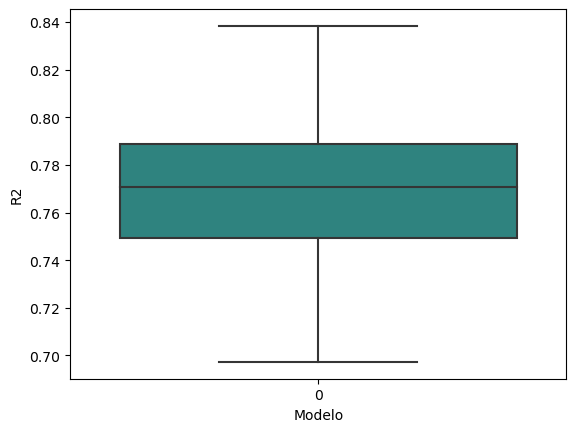

In [9]:
# Validación cruzada

list_res = pd.DataFrame(map(lambda x: cross_val_lin(x,FEV_data_noId, seed=5680),[formula]))
results = list_res.T.melt() # Aplico Transponse y melt
results.columns = ['Modelo','R2'] # Asigno que variable1 sea Modelo, y la variable2 sea R2

# Boxplot paralelo para comparar
sns.boxplot(x='Modelo',y='R2',data=results,palette='viridis')

A la vista de los resultados. ¿Está sobreajustando tu modelo al conjunto de entrenamiento?

**Respuesta**:

> El coeficiente de determinación medio R2 que hemos obtenido, es de 0.768, con una dispersión de 0.029. 
Algo muy similar a los resultados que obtuvimos ajustando en el training, con un R2 de 0.775, esto nos hace pensar que el modelo no está sobreajustado. 

## Pregunta 5

Indica el código necesario para leer el conjunto de datos **"IPI_Esp.xlsx"** y muestra su cabeza.

In [10]:
# Lectura de datos IPI

IPI_data= pd.read_excel('Datos\\IPI_Esp.xlsx')

# Primeras filas
IPI_data.head()

Date  IPI Nacional
0      1975M01        70.658
1      1975M02        72.180
2      1975M03        75.732
3      1975M04        74.844
4      1975M05        74.210

## Pregunta 6

Convierte el conjunto en una serie temporal legible para Python y representa gráficamente la evolución. 

In [11]:
# Conversión a serie temporal legible

# Reemplazo los carácteres 'M' por '-'
IPI_data['Month'] = IPI_data.iloc[:,0].apply(lambda x: x.replace('M','-'))

#Elimino el campo residual Date
IPI_data = IPI_data.drop(['Date'],axis=1)

In [12]:
# Convertir en date-time
IPI_data.set_index(['Month'],inplace=True)
IPI_data.index=pd.to_datetime(IPI_data.index)


In [13]:
# Mostrar valores de serie
IPI_data.head()


IPI Nacional
Month                   
1975-01-01        70.658
1975-02-01        72.180
1975-03-01        75.732
1975-04-01        74.844
1975-05-01        74.210

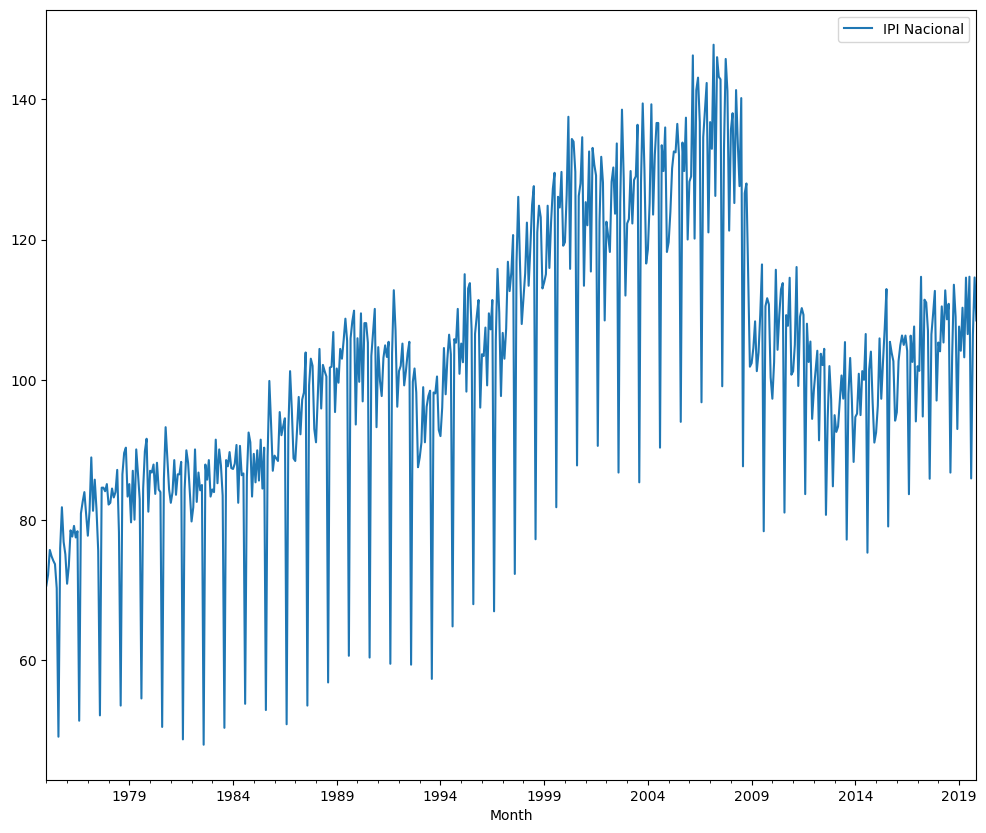

In [14]:
# Gráfico de evolución del IPI

plt.rcParams["figure.figsize"] = (12,10)
IPI_data.plot()
plt.show()

¿Qué componentes de la serie se pueden intuir en el gráfico?

**Respuesta**:

- La serie presenta una marcada tendencia creciente de forma consistente desde su inicio hasta el 2008, donde se puede ver una bajada considerable en cuanto a la tendencia que se estabiliza en 2014 y de nuevo inicia lo que parece ser de nuevouna tendencia creciente hasta 2019. En general podríamos considerar que la tendencia de la serie es creciente.

- Se puede observar una clara estacionalidad, donde generalmente los meses de Agosto de cada año se produce una caida abrupta de los valores para tener una pronta recuperación. Algo que esperaríamos entendiendo la naturaleza del IPI el Indice de Producción Industrial, esa bajada en los valores del IPI indica que en el mes de agosto de todos los años bajan los niveles de producción en la industria española de forma considerable.

- A priori, no se observa heterocedasticidad en la serie.

- Estaríamos ante una serie no estacionaria, ya que la media y la variabilidad cambian a lo largo del tiempo.

## Pregunta 7

Toma una partición con ventana de entrenamiento (todo el histórico hasta diciembre de 2017) y prueba (2018 y 2019). Ajusta el modelo de suavizado que consideres más adecuado a la luz de las características de la serie. Evalua el modelo en términos de error y adecuación de los residuos. ¿El modelo satisface las condiciones residuales en cuanto a  autocorrelaciones?

In [15]:
# Partición de datos
#Generamos la serie 
#training -> [:,2017-12-01]
#test     -> [2018-01-01:2019-12-01]

IPI_data_tr = IPI_data[:'2017-12-01']
IPI_data_tst = IPI_data['2018-01-01':]

IPI_data_tr.head()

IPI Nacional
Month                   
1975-01-01        70.658
1975-02-01        72.180
1975-03-01        75.732
1975-04-01        74.844
1975-05-01        74.210

In [16]:
IPI_data_tst.head()

IPI Nacional
Month                   
2018-01-01       105.313
2018-02-01       104.060
2018-03-01       110.466
2018-04-01       105.317
2018-05-01       112.755

Atendiendo a lo que hemos visto en el gráfico, vamos a probar el suavizado de Holt Winters,
que es un buén suavizado para aplicar a series con tendencia creciente y estacionalidad, de los modelos de suavizado de Holt Winters, podemos elegir entre suavizados aditivos multiplicativos que vienen bien a series que presentan heterocedasticidad,
o el suavizado multiplicativo, que viene bien para series con homocedasticidad. En nuestro caso voy a elegir un suavizado de Holt Winters aditivo, ya que en principio no considero que la serie presente heterocedasticidad.

                       ExponentialSmoothing Model Results                       
Dep. Variable:             IPI Nacional   No. Observations:                  516
Model:             ExponentialSmoothing   SSE                           9496.245
Optimized:                         True   AIC                           1534.873
Trend:                         Additive   BIC                           1602.811
Seasonal:                      Additive   AICC                          1536.249
Seasonal Periods:                    12   Date:                 Thu, 14 Mar 2024
Box-Cox:                          False   Time:                         22:49:30
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2680182                alpha                 True
smoothing_trend          

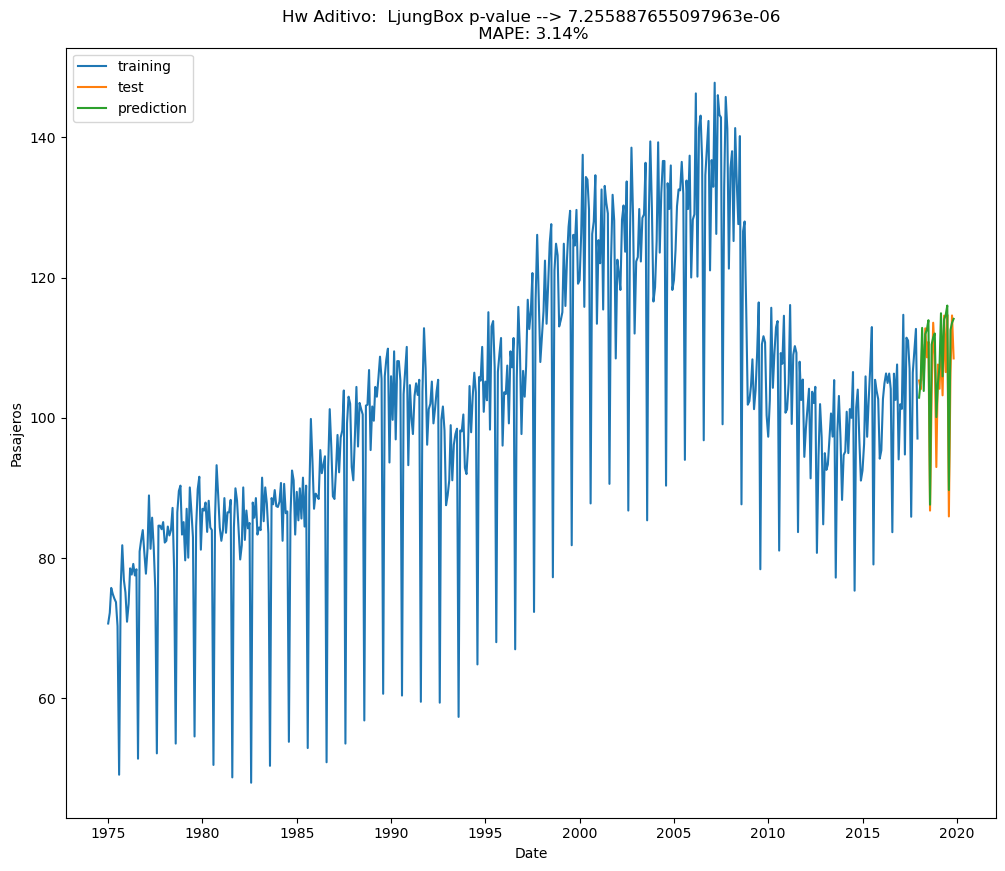

7.255887655097963e-06


In [17]:
# Ajuste de modelo de suavizado

hw_add = ets.ExponentialSmoothing(IPI_data_tr,trend='add', damped_trend=False, seasonal='add').fit()
print(hw_add.summary())

eval_model(hw_add,IPI_data_tr,IPI_data_tst,'Hw Aditivo')

# Los residuos que deja el suavizado de Holt Winters Aditivo, no pasan el test de ljungbox (pvalue -> 7.255 e-6 ).
# Error Medio Absoluto en % -> 3.14%

***Autocorrelaciones con intervalos de confianza***

<p>Además del test de ljungbox, vamos a evaluar los correlogramasa de los residuos</p>

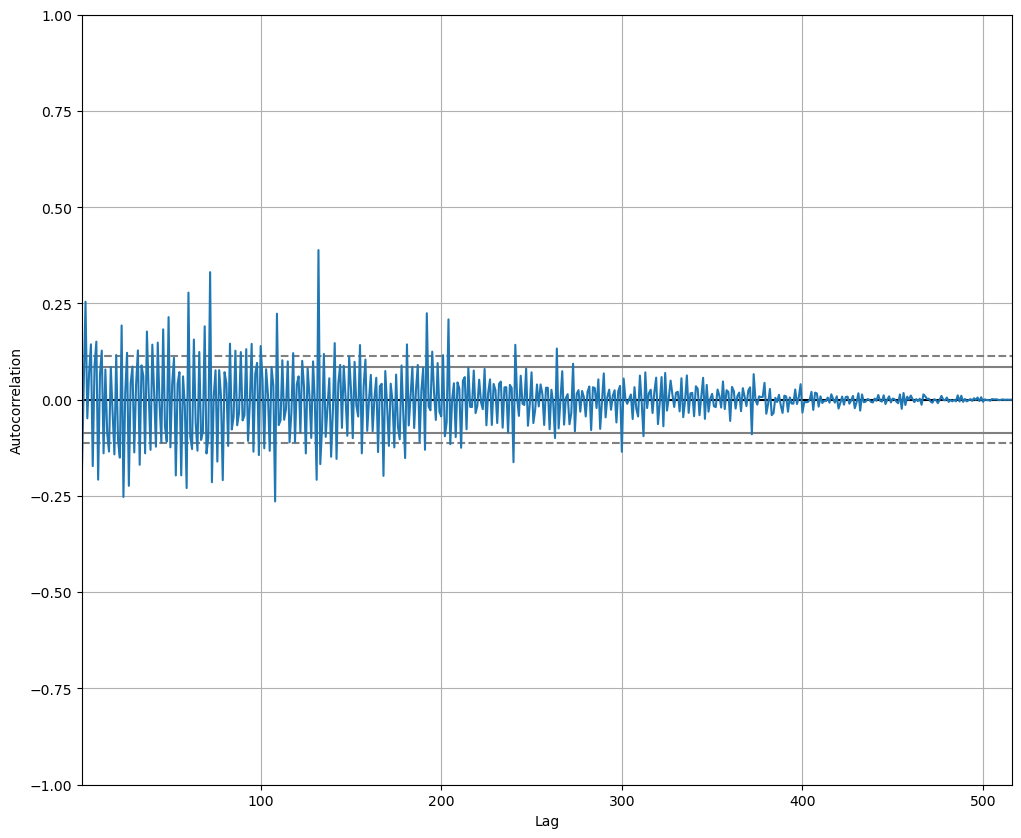

In [18]:
plt.clf()
autocorrelation_plot(hw_add.resid)
plt.show()

**Respuesta**:

   - Resultado suavizado HW Aditivo: 
       - Test de ljungbox fallido, (pvalue -> 7.255 e-6 ), es decir, hay una correlación en esos residuos. Buscamos un valor > 0.05.
       - Error Medio Absoluto en % -> 3.14%, no podemos comparar con otro modelo, pero nos serviría de referencia.
   
       - El modelo de suavizado de Holt Winters aditivo, nos da un resultado bastante malo en cuanto a correlacion de residuos, en el test de Ljungbox buscamos un p-valor > 0.05, además esto se corrobora en la grafica de autocorrelaciones con los retardos, buscamos que todos los residuos estén dentro de la banda de confianza al 95%, cosa que no ocurre y por mucho, como ya vimos en el test de ljung-box, hay mucho margen de mejora en nuestro model en este sentido.

## Pregunta 8

Presenta los correlogramas simple y parcial de la serie diferenciada en lo regular y estacional para el conjunto de entrenamiento. 

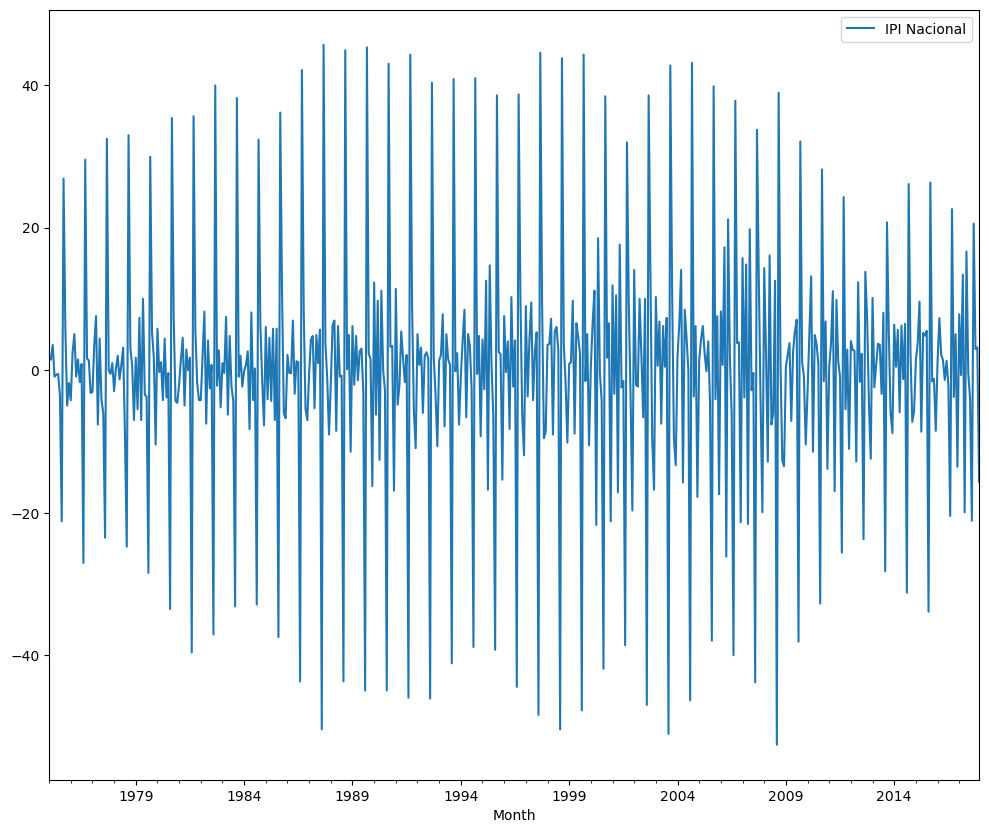

In [19]:
# Diferenciar serie

#Diferenciacion regular

IPI_data_tr_diff_1 = IPI_data_tr.diff(periods=1)
IPI_data_tr_diff_1.plot()
plt.show()

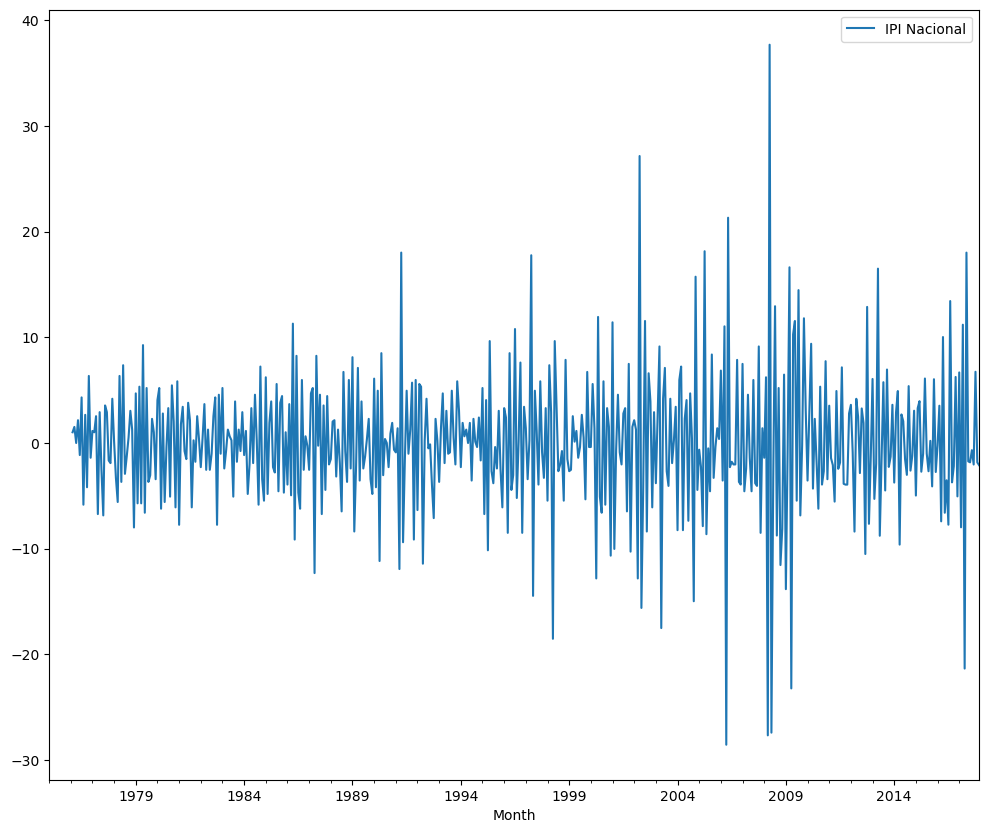

In [20]:
#Diferenciación Estacional

IPI_data_tr_diff_1_12 = IPI_data_tr_diff_1.diff(periods=12)
IPI_data_tr_diff_1_12.plot()
plt.show()

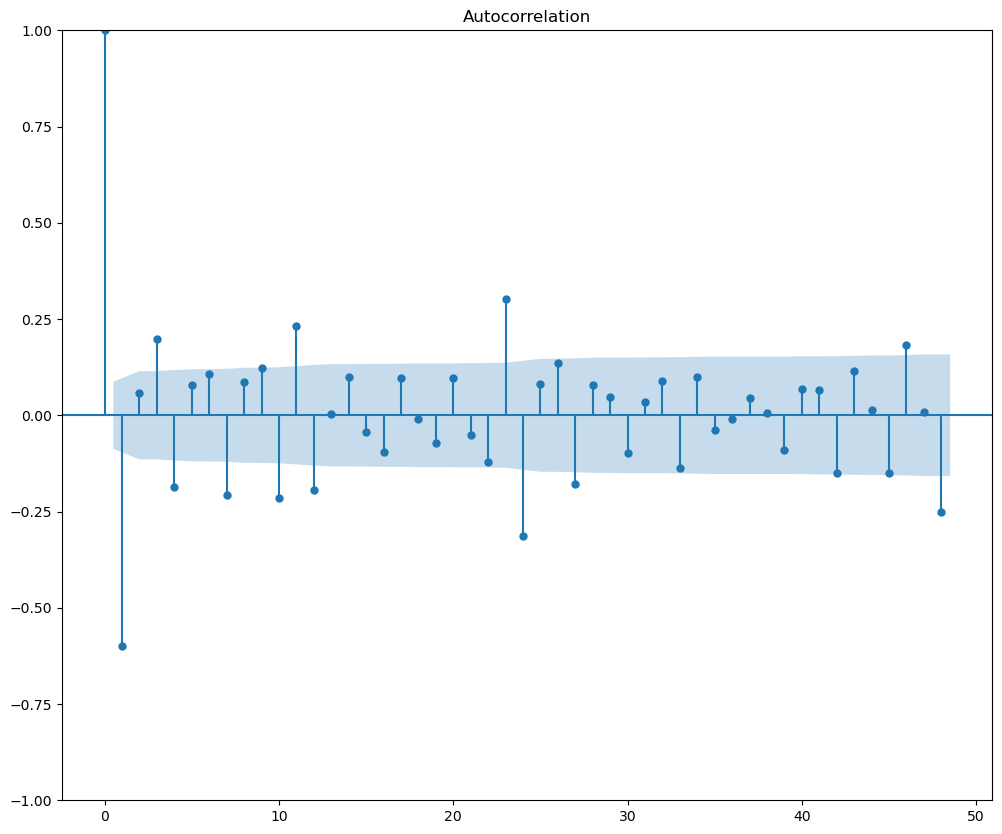

In [21]:
# Correlograma simple ACF
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(IPI_data_tr_diff_1_12.dropna(inplace=False),lags=48)
plt.show()

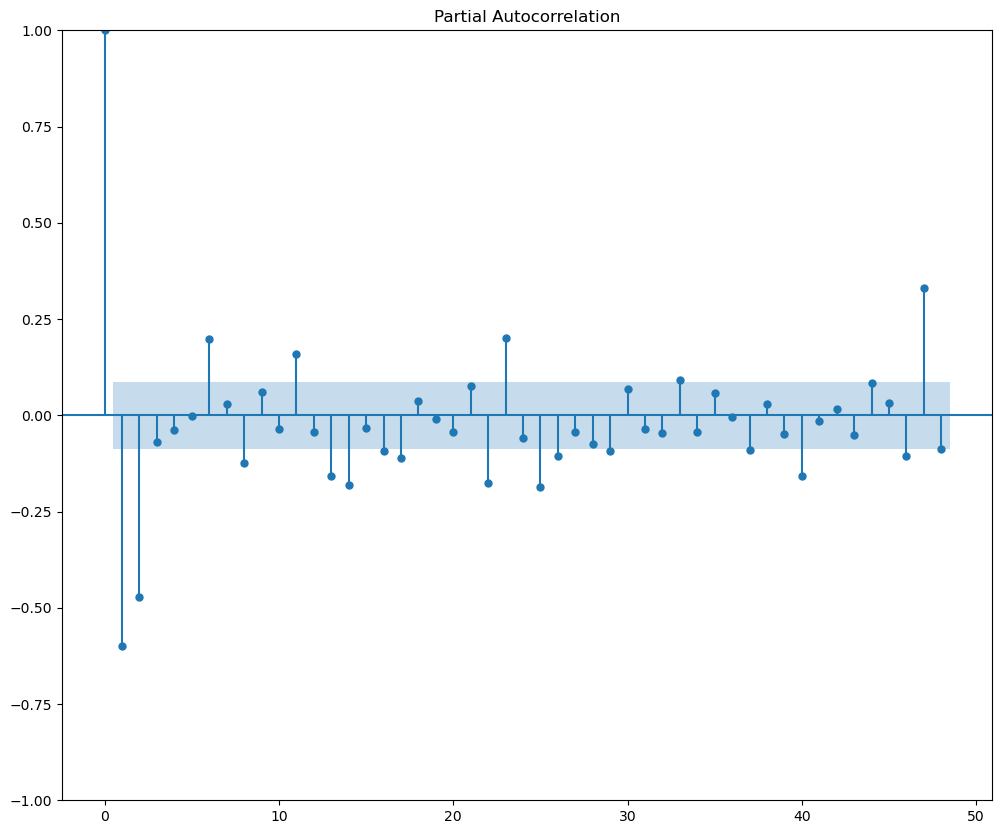

In [22]:
# Correlograma parcial PACF

plot_pacf(IPI_data_tr_diff_1_12.dropna(inplace=False),lags=48,method='ywm')
plt.show()

A pesar de la dificultad, intentemos proponer algunos órdenes en lo regular y estcional para un tentativo modelo arima. 

¿Cual sería tu primer modelo a probar según lo que observas en la desaparición de las correlaciones con los retardos?

**Respuesta**:

La serie como ya vimos, hay que diferenciarla una vez en lo regular y una vez en lo estacional para conseguir estacionalidad.

Veo un decrecimiento rapido del ACF, y un corte en el segundo retardo (PACF), eso me hace pensar en un AR de orden 2. A su vez puedo intuir un decrecimiento del PACF, y corte en el primer retardo del ACF, es decir veo indicios de tener delante un AR grado 2 MA grado 1.
    
El ACF, en lo estacional el retardo 12 es significativo, y el 24 tambien. El PACF en cuanto a lo estacional no tiene los retados 12 y 24 significativos.

No tengo muy claro la parte estacional pero probaría con un modelo (2,1,1)(2,1,1, 12)

## Pregunta 9

Ajusta ese modelo que propones y evalúa su capacidad de ajuste en test y la adecuación de residuos. 

In [23]:
# Ajuste de modelo ARIMA

arima1 = SARIMAX(IPI_data_tr, 
                 
                #* Parte regular (p,d,q)
                order = (2, 1, 1), 
                #* Parte estacional (P,D,Q)
                seasonal_order =(2, 1, 1, 12))
  
arima_1 = arima1.fit()

In [24]:
# Summary del modelo 
arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       IPI Nacional   No. Observations:                  516
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -1410.996
Date:                            Thu, 14 Mar 2024   AIC                           2835.993
Time:                                    22:49:31   BIC                           2865.537
Sample:                                01-01-1975   HQIC                          2847.583
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6367      0.088     -7.272      0.000      -0.808      -0.465
ar.L2         -0.3321      0.062     -5.398      0.000      -0.453      -0.212
ma.L1         -0.2631      0.080     -3.272      0.001      -0.421      -0.105
ar.S.L12       0.1418      0.076      1.877      0.060      -0.006       0.290
ar.S.L24      -0.2382      0.047     -5.115      0.000      -0.329      -0.147
ma.S.L12      -0.6558      0.061    -10.669      0.000      -0.776      -0.535
sigma2        15.7002      0.709     22.147      0.000      14.311      17.090
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               125.26
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

¿Son todos los efectos significativos en el modelo?

**Respuesta**: 

No, en el summary podemos ver que ar.S.L12, el término autorregresivo (AR) estacional de lag 12 en el modelo SARIMA, obtiene un p valor de 0.06 un poco por encima del valor limite de 0.05, todos los demás valores que obtenemos si son significativos.

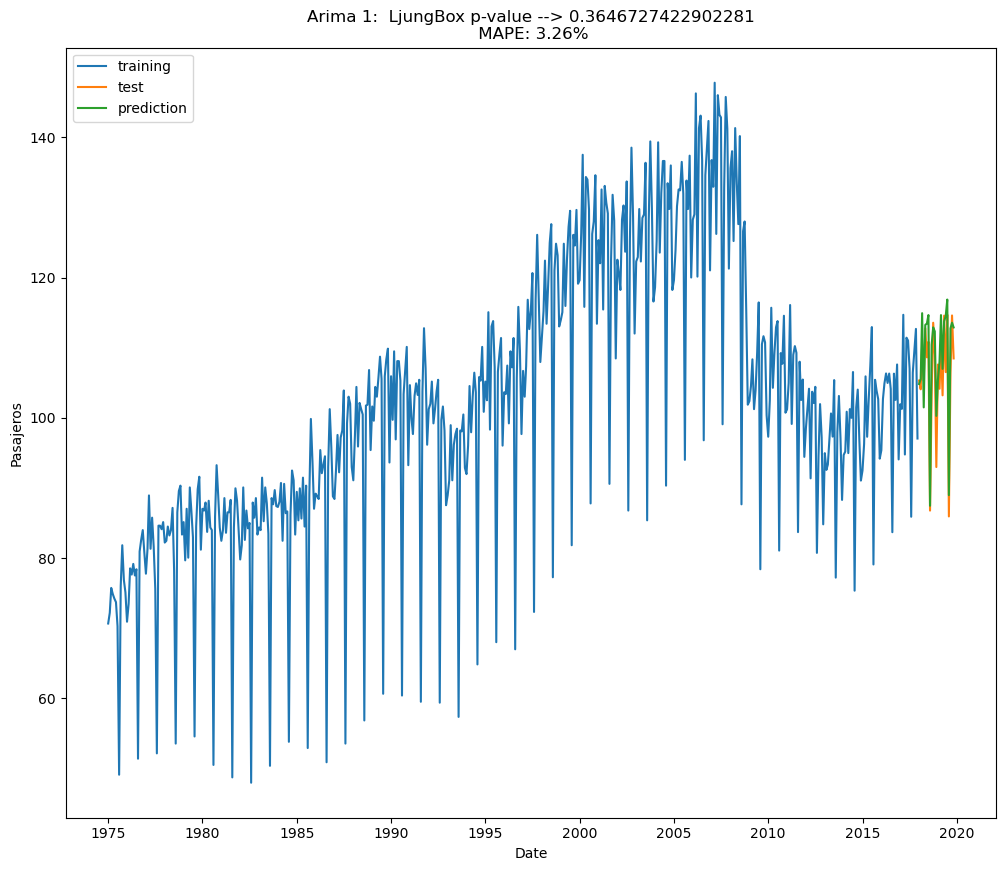

0.3646727422902281


In [25]:
# Evaluación del modelo (eval_model)
eval_model(arima_1,IPI_data_tr,IPI_data_tst,'Arima 1')

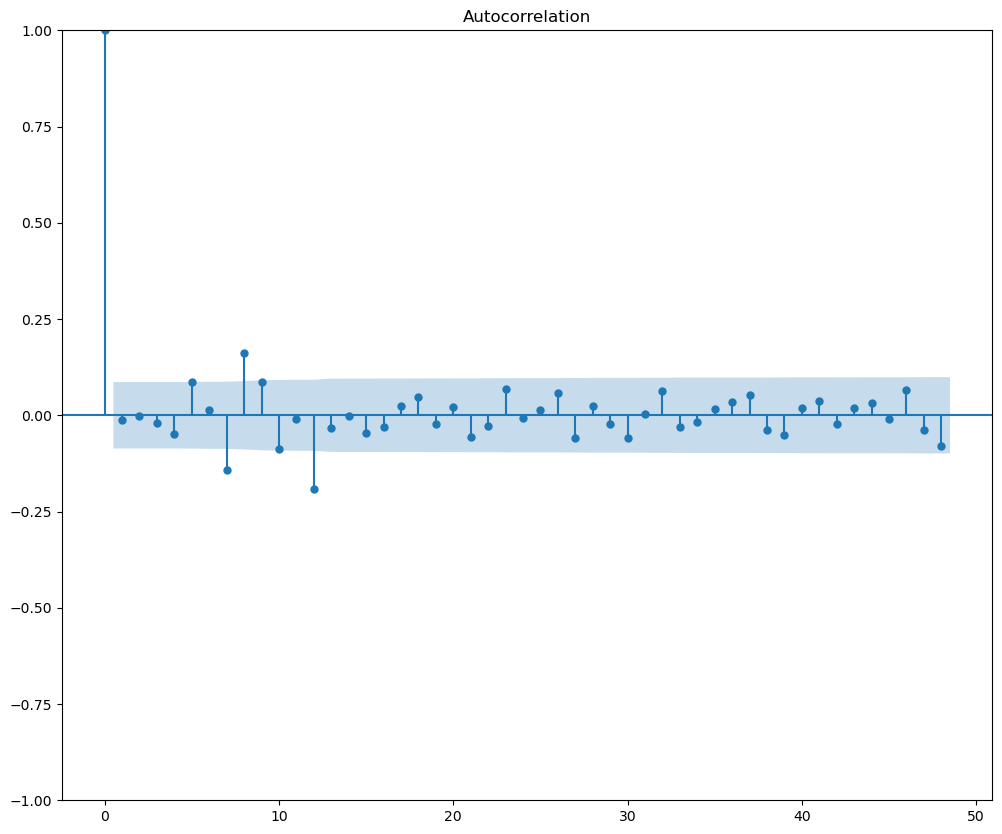

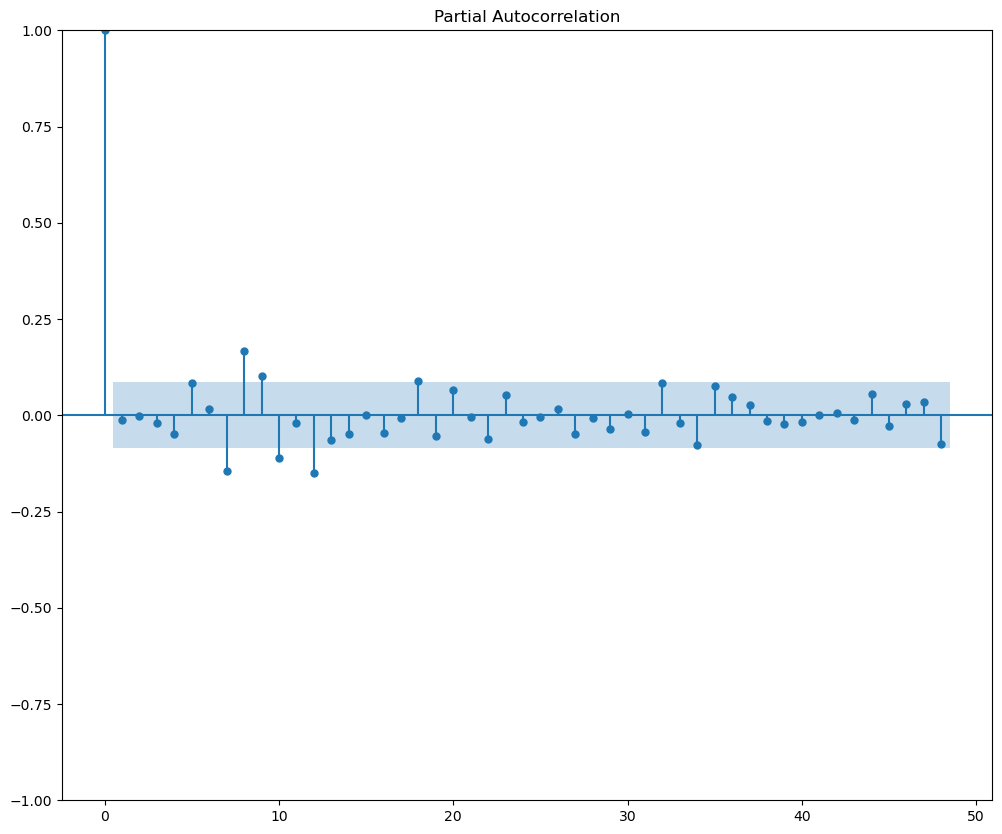

In [26]:
plot_acf(arima_1.resid,lags=48)
plt.show()
plot_pacf(arima_1.resid,lags=48,method='ywm')
plt.show()

¿Es tu modelo válido para la predicción en términos de adecuación residual? En caso contrario, juega con los órdenes para obtener un modelo que satisfaga el test de residuos. ¿Es este modelo aceptable mejor que el suavizado en términos de capacidad de predicción en el conjunto de test? 

**Respuesta**: 

Obtenemos un test de Ljungbox aceptable ( 0.36 ), estableciendo que pasamos el test de residuos.

Con el modelo de suavizado de HW aditivo, obtuvimos un MAPE de 3.14%, es decir en cuanto a  predicción, mi modelo SARIMA tiene mayor error de predicción que el modelo con suavizado HW aditivo, un 3.26% frente a un 3.14%. Es decir, si tenemos que responder a la pregunta de cual es el mejor modelo en cuanto a capacidad de predicción, tenemos que decir que el modelo de suavizado, ese 3,14% de error es menor que el 3.26% del modelo SARIMA. Pero en cuanto a estabilidad, los resultados del test de ljungbox de uno y otro modelo nos indica que el modelo SARIMA es mucho más estable.

## Pregunta 10

Indica el código necesario para leer el archivo **"clientes_cluster.csv"** y mostrar sus primeros registros. 

In [27]:
# Lectura clientes_cluster

clientes_cluster= pd.read_csv('Datos\\clientes_cluster.csv')
clientes_cluster.head()

CustomerID  Gender   Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male  19.0                15.0                    39.0
1           2    Male  21.0                15.0                     NaN
2           3  Female  20.0                16.0                     6.0
3           4  Female  23.0                16.0                     NaN
4           5  Female  31.0                 NaN                    40.0

In [28]:
clientes_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              200 non-null    int64  
 1   Gender                  185 non-null    object 
 2   Age                     187 non-null    float64
 3   Annual Income (k$)      191 non-null    float64
 4   Spending Score (1-100)  182 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 7.9+ KB


## Pregunta 11

Evalúa la incidencia de valores perdidos por variable e imputa el archivo mediante el método multivariante basado en el algoritmo Iterativo por cadenas de Markov (IterativeImputer), generando un nuevo archivo completo **"clientes_imputed"** del que se mostrará la información para comprobar que efectivamente todos los registros contienen valores válidos.

In [29]:
#Incidencia de missings por variable en %
clientes_cluster.apply(lambda x: x.isna().sum()/x.count()*100) 

CustomerID                0.000000
Gender                    8.108108
Age                       6.951872
Annual Income (k$)        4.712042
Spending Score (1-100)    9.890110
dtype: float64

**Comentario**:

En cuanto a % de missings por variable, como variables con % más alto tenemos a Age, que llega al 7%, Gender al 8.10% y la variable spending score, se acercan a un 10% que es algo bastante común en datos reales, no llega a niveles críticos como serían de un 25% o 30%.

A partir de aqui siempre tenemos 2 opciones, la primera sería eliminar registros con ausencia de datos, que implica introducir un sesgo de selección de registros que no nos interesa visto el % de incidencia por variable, y la segunda opción que creo que es la más adecuada en este caso, seguir hacia adelante y pasar a imputar valores a missings.

Antes de proceder con las imputaciones, y para evitar fallos, recodifica *Gender* como una variable dummy (cualquier opción de código es bienvenida) en formato numérico y elimina el ID de cliente de cara al análisis.

In [30]:
# Recodificación de Gender como dummy
# Recodificación de Gender como dummy

# Defino una funcion para convertir la variable Gender en Dummy, de forma que la variable pase a llamarse Gender_Male, 
# y tome valores 0 en caso de Gender = Female, y 1 en caso de Gender = Male.
# Además se respetan los registros con valores NaN.

def map_gender(value):
    if value == 'Female':
        return 0
    elif value == 'Male':
        return 1
    else :
        return value

clientes_dummy =  clientes_cluster   
clientes_dummy['Gender_Male'] = clientes_cluster['Gender'].map(map_gender)
clientes_dummy.drop(columns=['Gender','CustomerID'], inplace=True)
#Transformo la variable Gender_Male a numérica para aplicarle la imputación multivariante Iterativa posteriormente.


clientes_dummy.head()

Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
0  19.0                15.0                    39.0          1.0
1  21.0                15.0                     NaN          1.0
2  20.0                16.0                     6.0          0.0
3  23.0                16.0                     NaN          0.0
4  31.0                 NaN                    40.0          0.0

In [31]:
# Imputación multivariante Iterativa

imputer_itImp = skl_imp.IterativeImputer(max_iter=10, random_state=0)
clientes_imputed = pd.DataFrame(imputer_itImp.fit_transform(clientes_dummy),columns=clientes_dummy.columns)

# Info del archivo imputado
clientes_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     200 non-null    float64
 1   Annual Income (k$)      200 non-null    float64
 2   Spending Score (1-100)  200 non-null    float64
 3   Gender_Male             200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


¿Observas alguna cosa extraña en las imputaciones? En caso afirmativo, ¿cuál es tu conclusión?

**Respuesta:**

Si, se han imputado valores con decimales, cosa que no me interesa, es evidente en la variable Gender_Male, pero me quedo más tranquilo si redondeo en todas,  y convierto a enteras, ya que por definición son todas enteras.


Como posibilidad para revertir el extraño comportamiento, redondea la variable categórica y conviértela otra vez en entera.

In [32]:
# Arreglo de cosas extrañas en variable categórica

#Voy a redondear las variables, además de pasarlas de tipo float a tipo int.

# Redondear decimales y convertir a entero
clientes_imputed['Age'] = clientes_imputed['Age'].round().astype(int)
clientes_imputed['Gender_Male'] = clientes_imputed['Gender_Male'].round().astype(int)
clientes_imputed['Annual Income (k$)'] = clientes_imputed['Annual Income (k$)'].round().astype(int)
clientes_imputed['Spending Score (1-100)'] = clientes_imputed['Spending Score (1-100)'].round().astype(int)

clientes_imputed.head()

Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
0   19                  15                      39            1
1   21                  15                      58            1
2   20                  16                       6            0
3   23                  16                      57            0
4   31                  61                      40            0

In [33]:
# Mostrar la información actualizada del DataFrame
clientes_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Age                     200 non-null    int32
 1   Annual Income (k$)      200 non-null    int32
 2   Spending Score (1-100)  200 non-null    int32
 3   Gender_Male             200 non-null    int32
dtypes: int32(4)
memory usage: 3.3 KB


## Pregunta 12

Explora los métodos de clustering jerárquico para formar grupos de clientes similares en cuanto a su comportamiento en estas 4 variables disponibles y presenta sus dendogramas.

Vale, pero antes de nada, ¿consideras necesario realizar el escalado de los datos previo al clustering? ¿por qué?

**Respuesta:**

Es imprescindible analizar siempre si hay que aplicar el escalado de los datos antes de aplicar clustering, esto se debe a que diferentes escalas implican diferentes distancias de unos datos respecto a otros, por lo que a la hora de calcular distancias en el proceso de clustering, pesarían mucho más unos conjuntos de datos que otros.

En nuestro dataset, tenemos valores en escala de decenas frente a valores unitarios, por lo que entendemos que es imprescindible aplicar escalado.

In [34]:
# Clustering jerárquico bucle de dendogramas

# Escalado de datos
X_scaled = scale(clientes_imputed)    

ward :	0.00s


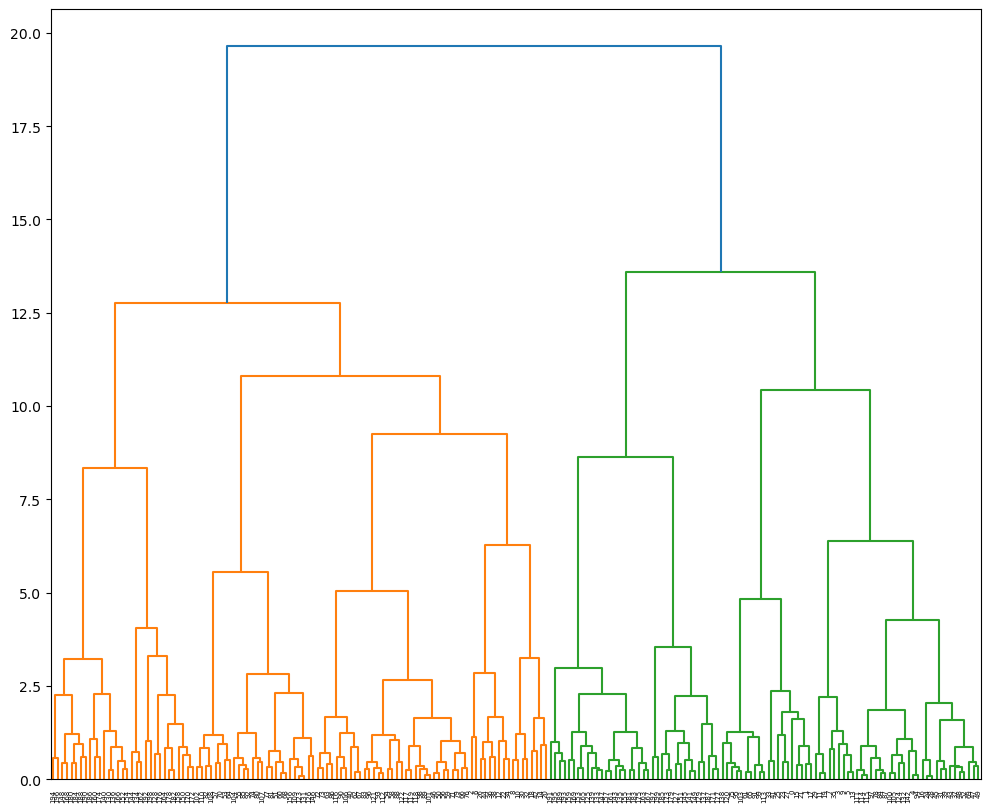

average :	0.00s


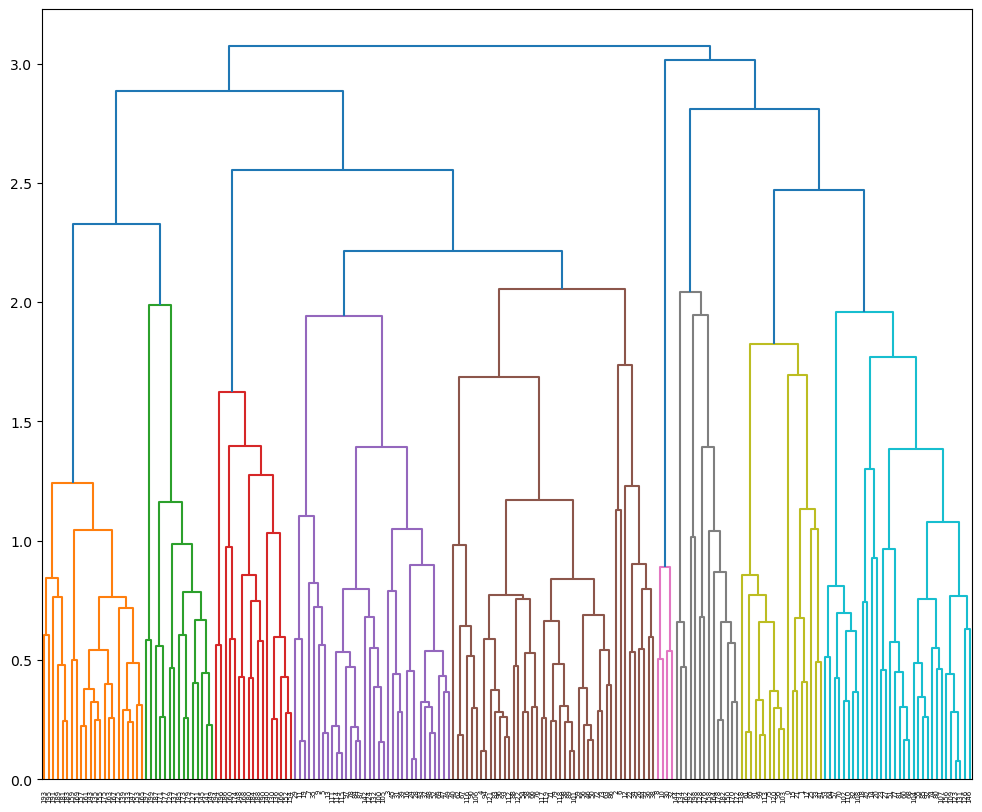

complete :	0.00s


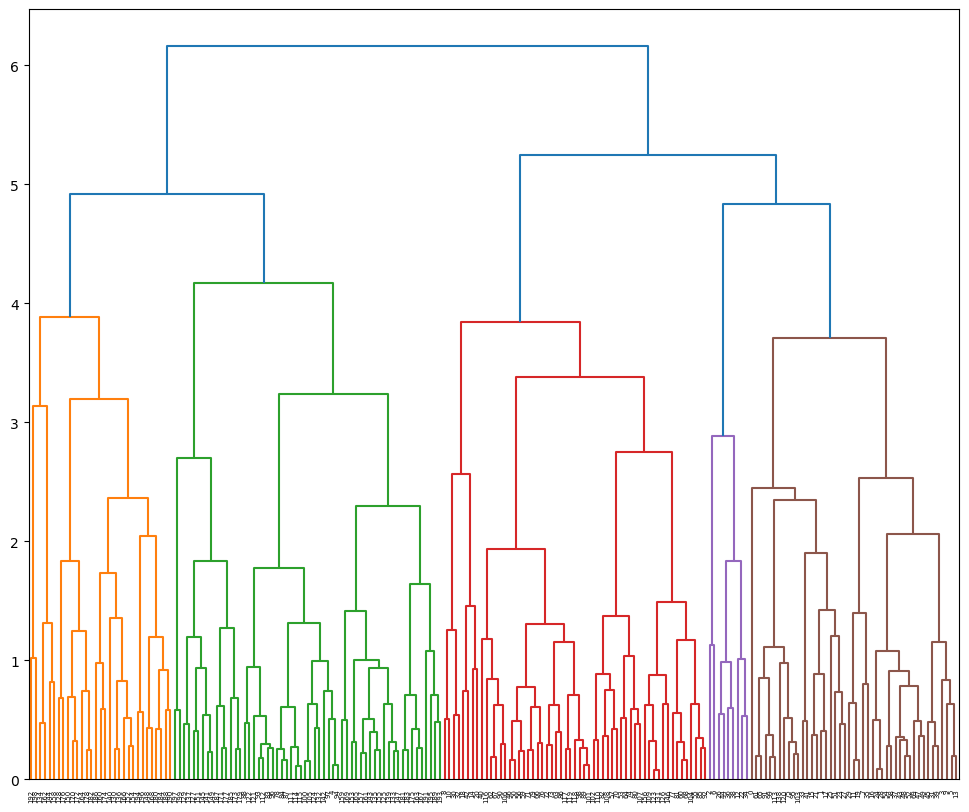

single :	0.00s


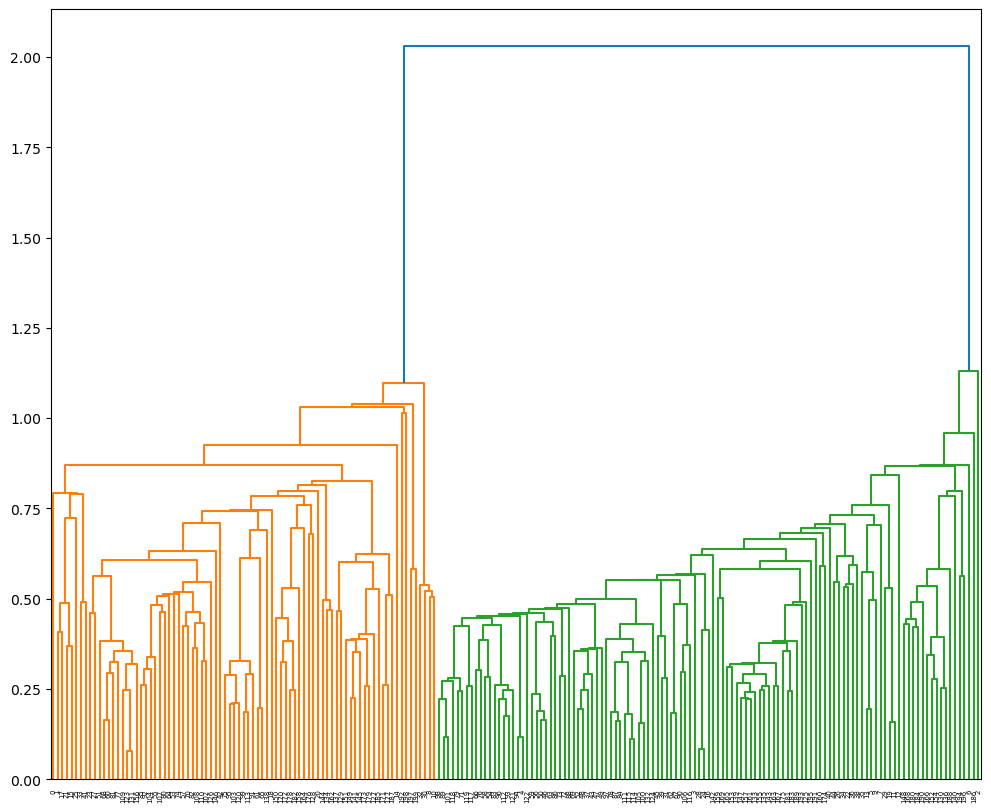

In [35]:
for linkage in ("ward", "average", "complete", "single"):
    #Defino el clustering
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None, #No ponemos el numero de clusters por que no lo sabemos a priori
                            distance_threshold = 0)
    t0 = time()
    
    #Ajusto el modelo a la X escalada.
    clustering.fit(X_scaled)
    
    #* Mostramos el linkage al que pertenece el dendograma siguiente
    print("%s :\t%.2fs" % (linkage, time() - t0))
    
    plt.clf()
    #Pintamos el dendograma
    plot_dendogram(clustering)
    #plot_clustering(X_scaled, clustering.labels_, "%s linkage" % linkage)

¿Cuál es el método de linkage más adecuado a la vista de los dendogramas? ¿Cuantos grupos de clientes formarías en base a las alturas del dendograma del linkage escogido?

**Respuesta**:

El metodo single lo descarto por estar demasiado enmarañado todo. Y con el método average, obtenemos un dendograma con poca claridad a la hora de realizar el corte y obtener un conjunto de grupos homogeneo, por lo que también lo descarto.

El método ward observo que hay un corte claro obteniendo 9 grupos, donde posiblemente se establezca la mayor distancia entre la solución inmediatamente anterior y posterior. El siguiente corte, lo pegaría con 2 grupos pero es bastante más arriba en el dendograma.

Con el método complete, observo que donde se establece la mayor diferencia entre distancias de la solución inmediatamente anterior y posterior es haciendo 5 grupos, pero queda un grupo bastante poco representativo( grupo morado) que no me gusta. Los demás puntos de corte no los veo demasiado claros.

Es decir, probaría ward 9, aunque son demasiados grupos teniendo en cuenta que estamos realizando agrupaciones sobre 200 registros, de media estamos estableciendo unos 22 registros por grupo con 9 grupos. Después me iría a ward 2 y complete 5. Sacaría los valores de silueta, varianza intra y el calinski harabasz score en los 3 casos y me quedaría con el más eficiente. 

Pero según las alturas del dendograma, tengo que elegir el ward 9, a pesar de lo comentado con aterioridad del número de grupos elevado. Además como argumento en contra de elegir 9 grupos, está el límite que hemos establecido teoricamente de 8-9 grupos como máximo, pero no puedo dejar pasar la oportunidad de probar 9 grupos, las evidencias visuales parecen robustas.
Además para corroborar esta elección de tantos grupos, he probado a calcular los difentes valores de silueta y de calinski harabasz score para las distintas combinaciones, teniendo la elección de ward9 los valores más significativos.

## Pregunta 13

Explora el clustering K-means con distinto número de grupos y decide cuantos el número de clusters óptimo para la solución según este método. Comenta las métricas de evaluación.

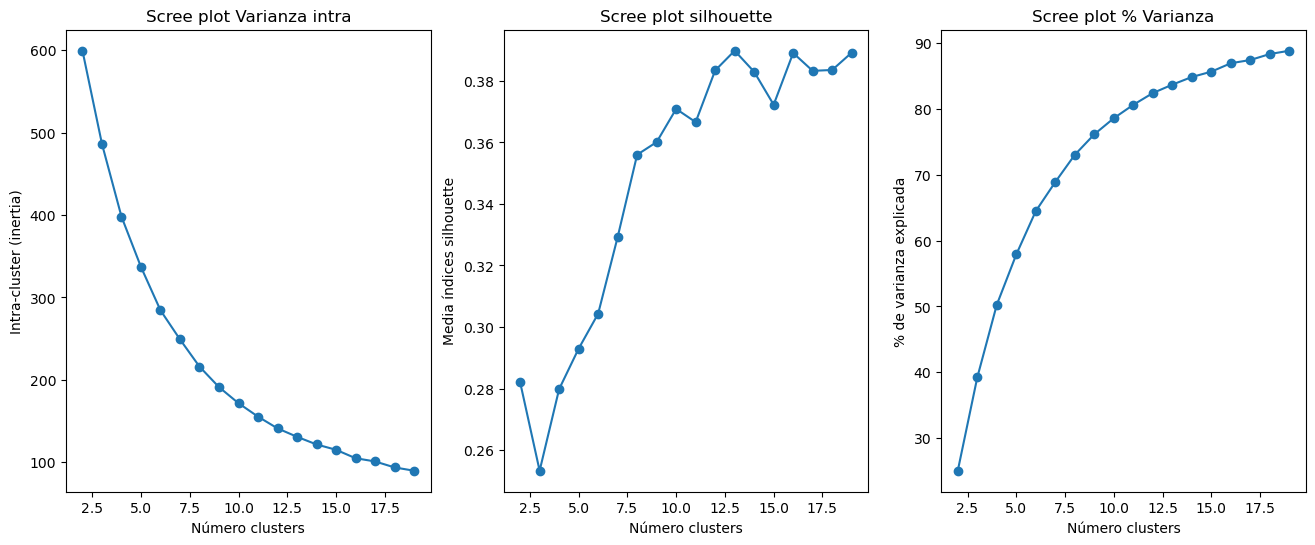

In [36]:
# Clustering k-means evaluación número clusters

scree_plot_kmeans(clientes_imputed,20)
plt.show()

**Respuesta**: 

Evaluando los gráficos de Varianza intra, silueta y varianza explicada obtenemos el siguiente resultado de aplicar kmeans configurado desde 1 a 20 grupos.

- La varianza intra, disminuye conforme aumentan los grupos, un comportamiento lógico. Podemos observar que a partir de alrededor de los 7-10 grupos, empieza a aplanarse la curva y disminuye el ritmo con el que va mejorando la varianza intra.

- En Silueta vemos como tenemos una gráfica bastante creciente con una bajada abrupta en los 2 clusters, en el valor 8, encontramos una relajación en el ritmo de subida y a partir de ahi, encontramos un pico bastante interesante en los 10 clusters, hasta encontrar un segundo pico en los 13. 

- En el gráfico de % de varianza explicada, vemos un comportamiento logarítmico, donde antes de los 7 clusters, no llegamos ni al 70% de varianza explicada, y pasamos del 80% en los 11 clusters.

- Por los datos que mostramos con anterioridad en el dendograma que elegimos visualmente 9 grupos, y por lo visto en estas gráficas, el plot de varianza me hace pensar que el número de grupos óptimo debe de ser de 8 hacia adelante.

- Los valores de silueta, son muy pobres, no se acercan al valor unitario ni de lejos, y vemos picos interesantes en los valores 10 y 13, pero el decrecimiento en el ritmo de subida del valor8, hace que nos quedemos con ese valor en cuanto a silueta.

- La curva de varianza explicada, al menos buscaríamos un 80% es decir sobrepasamos los 10 grupos.

Según estos valores, voy a elegir 8 grupos, ya que el límite de grupos teórico no debería sobrepasar los 8-9, creo que la elección más robusta son los 8 grupos, atendiendo a que superar esa cifra no nos interesa.

Ajusta el clustering K-means con el núemero de grupos seleccionado y genera una nueva variable en el conjunto de datos imputado llamada *'Cluster'* que recoja el número de grupo asignado a cada registro. El tipo de la variable debe ser entero (int).  

In [37]:
#Ejecuto el modelo kmeans
modelo_kmeans = KMeans(n_clusters=8, n_init=25, random_state=123)

modelo_kmeans.fit(X=X_scaled)

KMeans(n_init=25, random_state=123)

In [38]:
# Creación de variable cluster
    
clientes_imputed['Cluster']=modelo_kmeans.labels_

Extrae los centroides de los grupos y comenta las principales características de cada grupo formado. 

In [39]:
#* Miramos los centroides.
print('Centroides')
print(modelo_kmeans.cluster_centers_)

Centroides
[[-0.46505604  0.96743426  1.21693464 -0.84225988]
 [ 1.48829431 -0.41779137 -0.49001849  1.187282  ]
 [ 0.85442896 -0.47668206 -0.31933232 -0.84225988]
 [-0.42320065  1.08341307  1.29633558  1.187282  ]
 [-0.08628311  1.04034776 -1.49367435  1.187282  ]
 [-0.87903881 -0.72539533  0.25886229 -0.84225988]
 [-0.79215445 -0.6242013   0.25661017  1.187282  ]
 [ 0.36557779  1.08328614 -1.0607534  -0.84225988]]


**Comentarios**: 
Al ser tantos grupos, es dificil identificar patrones respecto a la asignación de centroides.
Aún así es interesante ver como al ener 4 dimensiones (R4), se van intercalando signos entre ellos donde cada centroide tiene una asignación de signos especifica de cada dimension que no se vuelve a repetir.

Por ejemplo:

- 1er centroide: - + + -
- 2o  centroide: + - - +
- 3er centroide: + - - -
- ...

Tambien es importante indicar como se han escalado los datos, escalando todas las dimensiones entorno a los valores 0-1.

## Pregunta 14

De cara a la proyección de los grupos formados en el espacio de características y dado que estamos en R4. Nos planteamos reducir la dimensionalidad a 2 para poder interpretar con mayor claridad mediante un bonito biplot. 

Para llevar a cabo esta tarea, necesitaremos ajustar un PCA con 2 dimensiones a los **datos de entrada al clustering** que hemos generado, es decir, tal vez utilizamos el conjunto de datos escalado si lo consideramos necesario. Mostraremos las cargas de las variables en las componentes y haremos una pequeña interpretación inicial de las 2 componentes.


In [40]:
# Ajuste PCA 2 dimensiones

pcaModel = pca(normalize=True,n_components=2)
results = pcaModel.fit_transform(clientes_imputed.iloc[:,:4])

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 2 Principal Components explain [59.12%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

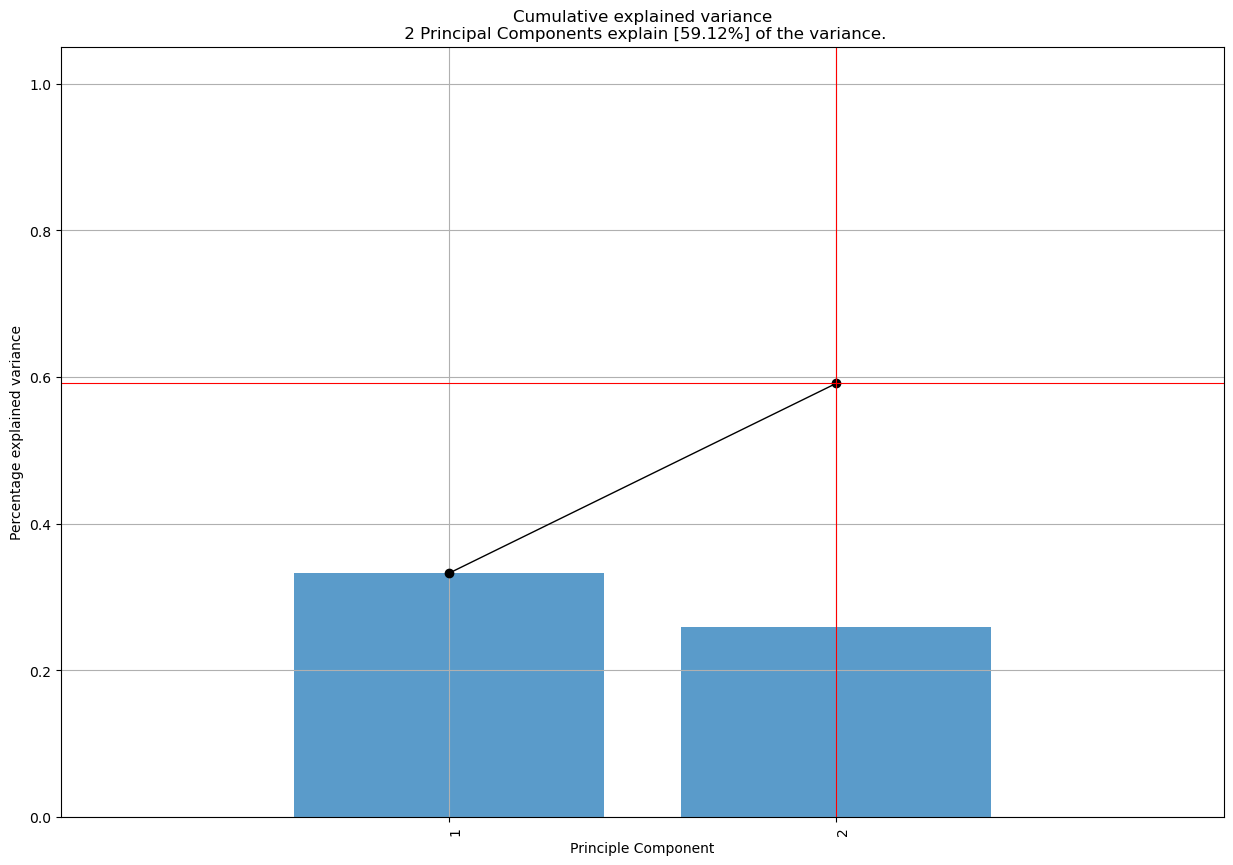

In [41]:
# Análisis de cargas

# Plot de la variabilidad
pcaModel.plot()

In [42]:
# Acceso a las cargas
pcaModel.results['loadings']

Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
PC1  0.696194           -0.081394               -0.702080     0.125592
PC2 -0.004001            0.725247                0.034952     0.687590

**Interpretación inicial**:

Tenemos 2 componentes definida por los siguientes valores:

Componente1 - Se explica en el sentido positivo de la edad (69%), y en el sentido negativo del spending score(-70%). Un aumento unitario de la componente1 implica aumento considerable de la edad, y disminución considerable del spending score. Podríamos interpretar la componente1 como personas adultas con un scoring malo. Ademas como asignamos el valor 0 de Gender_Male a Gender = Female y el valor 1 de Gender_Male a Gender = Male, visto que hay poco incremento del valor de Gender_Male, podemos deducir que Componente1 también habla de genero femenino.


Componente2 - Se explica en el sentido positivo de los ingresos (72%) y en el sentido positivo de Gender_Male (68%). Un aumento unitario de la componente2 implica un aumento considerable de ingresos anuales y de sexo masculino, como sexo es una variable dicotómica, podemos establecer que hay una tendencia conforme se incrementa el valor de PC2 de que los individuos sean hombres.

Además cabe indicar que nuestro modelo de 2 componentes, explica un 59.12% de la variabilidad de nuestro modelo real.

Ahora generamos y mostramos el biplot para interpretar con mayor seguridad las componentes. 

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '2 Principal Components explain [59.12%] of the variance'}, xlabel='PC1 (33.2% expl.var)', ylabel='PC2 (25.9% expl.var)'>)

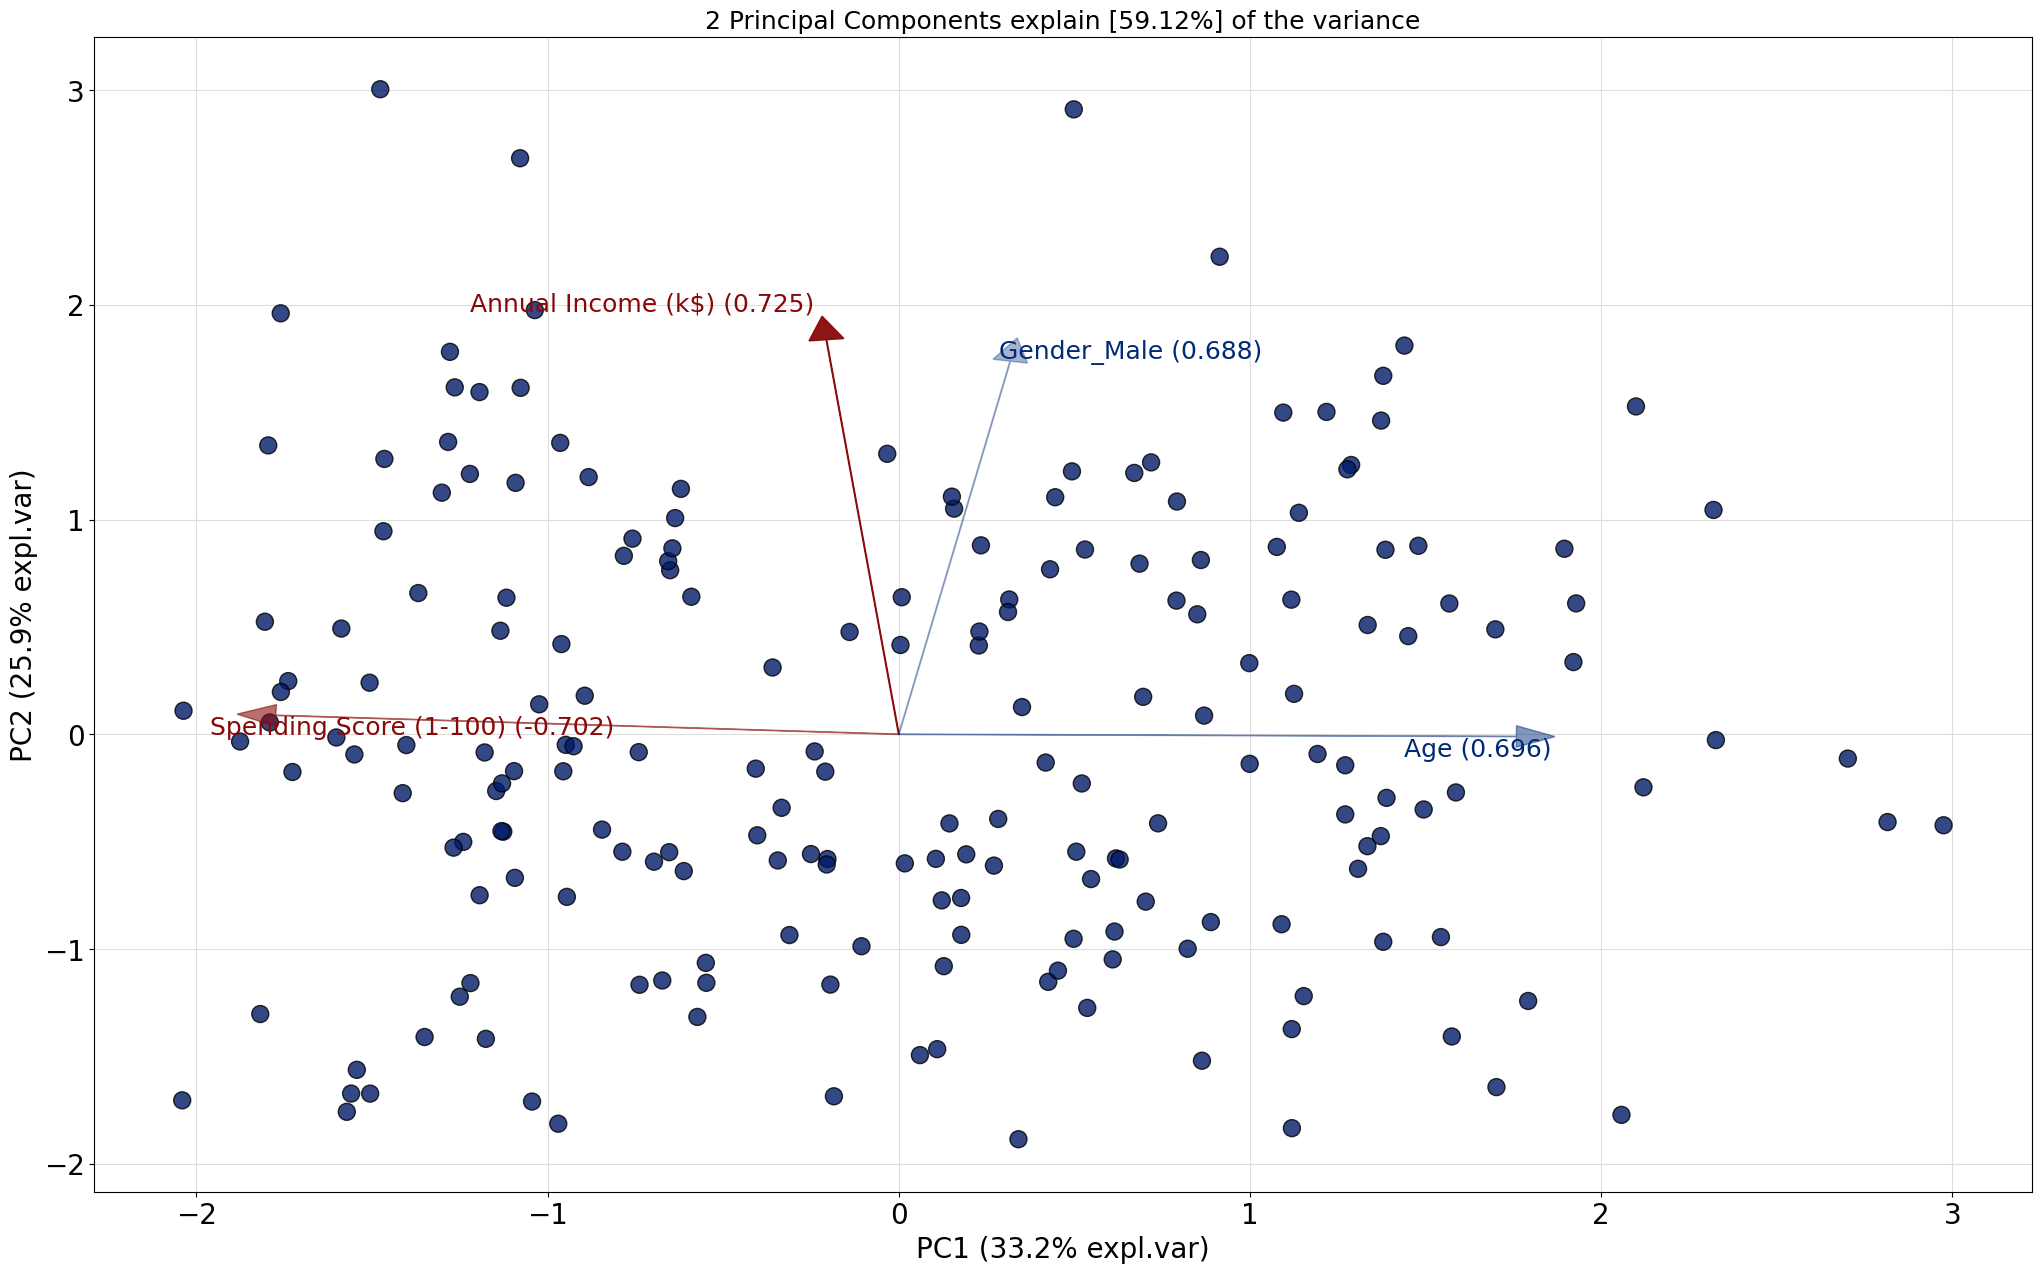

In [43]:
# Biplot

# Visualización biplot para interpretar componentes
pcaModel.biplot(legend=False)

**Interpretación gráfica**:

Como ya vimos en el análisis de cargas, componente horizontal PC1, explica en el sentido positivo la edad y en el sentido negativo el scoring, además la componente 1 explica un 33.2% de la variabilidad de nuestro modelo.

La componente vertical PC2, tiene que ver en el sentido positivo con la edad y con el valor de los ingresos anuales. Además esta componente 2 PC2, explica un 25.9% de la variabilidad del modelo.

Ahora que sabemos lo que represanta cada componente en el espacio original de las variables, necesitamos un conjunto de datos que contenga las columnas *PC1*,*PC2* y *Cluster* para realizar la representación de los clientes por grupos propuestos e interpretar las características de los grupos en el espacio de las componentes. 

In [44]:
# Creación dataset dimensión reducida

# Acceso a scores
pcaModel.results['PC']
clientes_pca = pcaModel.results['PC'].join(clientes_imputed['Cluster'])
clientes_pca.head()




PC1       PC2  Cluster
0 -0.403107 -0.470348        6
1 -0.845111 -0.443734        6
2  0.340666 -1.885425        5
3 -0.969711 -1.813275        5
4 -0.203263 -0.580719        5

In [45]:
# Representación de grupos en espacio de componentes

# Visualización del biplot por cluster
fig = px.scatter(clientes_pca, x='PC1',y='PC2', color='Cluster')
fig.show()

**Interpretación de biplot**: IMPORTANTE, al EJECUTAR de nuevo kmeans se asignan diferentes numeros de cluster a cada grupo, por lo que la explicación queda descolocada.

> En la evaluación de cargas, previamente, establecimos que la pertenencia de PC1 o PC2, tenían las siguientes implicaciones:

- PC1 - Edad+ Scoring-
- PC2 - Ingresos+ Gender_Male+

Por lo tanto evaluando la disposición de los grupos, sacamos las siguientes conclusiones:

- Cluster 0: valores PC1 negativos, y PC2 positivos - Lo conformarían clientes jovenes con un buen scoring, con bastantes ingresos y genero masculino.
- Cluster 1: valores PC1 positivos, y PC2 positivos - Lo componen clientes con Edad bastante adulta, scoring negativo, scoring altos y de genero masculino.
- Cluster 2: PC1 positivos, PC2 negativos - Clientes bastante adultos con mal scoring, que tienen pocos ingresos y son mayormente de genero femenino.
- Cluster 3: PC1 negativo y PC2 positivo -  Clientes jovenes con un buen scoring, con bastante ingresos y mayormente masculinos.
- Cluster 4: PC1 y PC2 bastante positivos - Clientes con una edad bastante adulta y un scoring mas bien negativo, además de tenes buenso ingresos y ser mayormente masculinos.
- Cluster 5: PC1 y PC2 bastante negativos - Clientes bastante jovenes con un scoring bueno, y unos ingresos más bien escasos, de género femenino.
- Cluster 6: PC1 negativo y PC2 positivo - Clientes jovenes con buen scoring, que tienen buenos ingresos y son mayoritariamente de genero masculino.
- Cluster 7: PC1 y PC2 moderadamente positivos - Clientes de edad media un scoring mas bien negativo, con unos ingresos medios y tendente a ser masculinos.


Al tener tantos grupos, es dificil de interpretar y que no haya algún tipo de solape en cuanto a alguna de las características generales de algún grupo respecto a otro, pero como vimos en los centroides, cada grupo va tomando diferente'signo' respecto a cada dimensión, por lo que cada grupo tiene una combinacion única de los signos de cada dimension.